In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import random
from glob import glob
from tqdm import tqdm
from scipy.io import loadmat

import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from audiomentations import *
import warnings
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from datetime import datetime
import json

In [2]:
data_dir = "/media/mountHDD2/khoibaocon"
print(os.listdir(data_dir))

['TrainingSet3', 'Label.csv', 'alldata', 'TrainingSet1', 'single_label.csv', 'TrainingSet2']


In [3]:
main_df = pd.read_csv(data_dir + "/Label.csv")
main_df.shape

(6877, 4)

In [4]:
main_df.head()

,Recording,First_label,Second_label,Third_label
0,A0001,5,NaN,NaN
1,A0002,1,NaN,NaN
2,A0003,2,NaN,NaN
3,A0004,2,NaN,NaN
4,A0005,7,NaN,NaN


In [5]:
main_df["First_label"].value_counts()

First_label
5    1695
2    1098
1     918
8     826
3     704
7     653
6     574
4     207
9     202
Name: count, dtype: int64

In [6]:
main_df["Second_label"].value_counts()

Second_label
5.0    162
2.0    123
7.0     47
6.0     42
8.0     41
4.0     28
3.0     18
9.0     16
Name: count, dtype: int64

In [7]:
main_df["Third_label"].value_counts()

Third_label
9.0    2
8.0    2
6.0    1
4.0    1
Name: count, dtype: int64

In [8]:
single_main_df = main_df[main_df["Second_label"].isnull()]
single_main_df.shape

(6400, 4)

In [9]:
# single_main_df.to_csv(data_dir + "/single_label.csv")

In [10]:
mat_files = glob(data_dir + "/alldata/*")
print(len(mat_files))

6877


In [11]:
single_fns = single_main_df["Recording"].values.tolist()
print(len(single_fns))

6400


In [12]:
single_mat_paths = [data_dir + f"/alldata/{x}.mat" for x in single_fns]
print(os.path.exists(single_mat_paths[0]))

True


In [13]:
sample_data = loadmat(single_mat_paths[0])
sample_data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'ECG'])

In [14]:
sample_signal_data = sample_data['ECG'][0][0][2]
sample_signal_data.shape

(12, 7500)

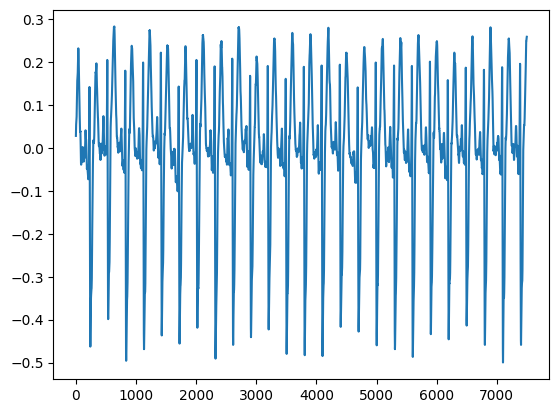

In [15]:
plt.plot(sample_signal_data[0])

In [16]:
sample_sig = torch.randn(1, 12, 32)
conv_test = nn.Conv1d(12, 12, 3, 1, 1)
print(conv_test(sample_sig).shape)

torch.Size([1, 12, 32])


In [17]:
# len_lst = [loadmat(x)['ECG'][0][0][2].shape[1] for x in single_mat_paths]
# print(f"MAX: {max(len_lst)}")
# print(f"MIN: {min(len_lst)}")
# print(f"AVG: {sum(len_lst)/len(len_lst)}")

In [18]:
class BasicBlock(nn.Module):
    def __init__(self, channel_num):
        super(BasicBlock, self).__init__()
        self.conv_block1 = nn.Sequential(
			nn.Conv1d(channel_num, channel_num, 3, padding=1),
			nn.BatchNorm1d(channel_num),
			nn.LeakyReLU(0.2),
		)
        self.conv_block2 = nn.Sequential(
			nn.Conv1d(channel_num, channel_num, 3, padding=1),
			nn.BatchNorm1d(channel_num),
		)
        self.relu = nn.LeakyReLU(0.2)
        torch.nn.init.kaiming_normal_(self.conv_block1[0].weight)
        torch.nn.init.kaiming_normal_(self.conv_block2[0].weight)
        
    def forward(self, x):
        residual = x
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = x + residual
        out = self.relu(x)
        return out

In [19]:
test_basic_block = BasicBlock(2)
sample_sig = torch.randn(1, 2, 32)
print(test_basic_block(sample_sig).shape)

torch.Size([1, 2, 32])


In [20]:
class ResNet(nn.Module):
    def __init__(self, in_channels = 12, type = 18, num_classes = 9):
        super(ResNet, self).__init__()
        self.struc_dict = {
            18: {
                "num_channels" : [64, 128, 256, 512],
                "counts" : [2, 2, 2, 2]
            }
        }
        self.conv1 = nn.Conv1d(in_channels=in_channels, out_channels=64, kernel_size=7, stride=2)
        torch.nn.init.kaiming_normal_(self.conv1.weight)
        self.max1 = nn.MaxPool1d(kernel_size=3, stride=2)
        self.main = nn.Sequential()
        for idx, struc in enumerate(
            zip(
                self.struc_dict[type]["num_channels"], 
                self.struc_dict[type]["counts"]
            )
        ):
            num_channel, cnt = struc
            for i in range(cnt):
                self.main.add_module(f"conv{idx+1}_{i}", BasicBlock(num_channel))
            if idx < len(self.struc_dict[type]["num_channels"]) - 1:
                self.main.add_module(f"ext_{idx}", nn.Conv1d(num_channel, self.struc_dict[type]["num_channels"][idx+1], 3, 1))
                self.main.add_module(f"extbn_{idx}", nn.BatchNorm1d(self.struc_dict[type]["num_channels"][idx+1]))
                                     
        self.avg = torch.nn.AdaptiveAvgPool1d((1))
        self.lin = nn.Linear(self.struc_dict[type]["num_channels"][-1], num_classes)
        torch.nn.init.kaiming_normal_(self.lin.weight)
    def forward(self, x):
        x = self.conv1(x)
        x = self.max1(x)
        x = self.main(x)
        x = self.avg(x)
        x = x.reshape(x.shape[0], -1)
        x = self.lin(x)
        return x

In [21]:
model = ResNet()
sample_sig = torch.randn(1, 12, 3000)
model(sample_sig).shape

torch.Size([1, 9])

In [22]:
class ECG(Dataset):
    def __init__(self, data_paths, label_df, train):
        self.data_paths = data_paths
        random.shuffle(self.data_paths)
        self.label_df = label_df
        self.train = train

    def __getitem__(self, idx):
        augment = Compose([
            AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.01, p=0.2),
            AddGaussianSNR(min_snr_db=3.0, max_snr_db=12.0, p=0.2),
            Gain(min_gain_db = -10.0, max_gain_db = 10.0, p =0.2),
            GainTransition(min_gain_db = -15.0, max_gain_db = 15.0, 
                           min_duration = 50, max_duration = 200, duration_unit = "samples", 
                           p = 0.2),
            TimeStretch(min_rate=0.8, max_rate=1.25, p=0.2),
            PitchShift(min_semitones=-4, max_semitones=4, p=0.2),
            Shift(min_fraction=-0.5, max_fraction=0.5, p=0.2),
        ])
        
        data_path = self.data_paths[idx]        

        filename = data_path.split("/")[-1].split(".")[0]
        label = self.label_df[self.label_df["Recording"] == filename]["First_label"].values.item()
          
        tensor_lst = []
        for i in range(12):
            data = loadmat(data_path)['ECG'][0][0][2][i]
            clip_data = data[300:]
            desired_length = 2500
            if self.train == True:
                pad_length = max(desired_length - len(clip_data), 0)
                if pad_length == 0:
                    padded_augment = clip_data[:desired_length]
                else:
                    padded_augment = np.pad(clip_data, (0, pad_length), mode='constant')

            else:
                augmented_samples = augment(samples=clip_data, sample_rate=500)
                pad_length = max(desired_length - len(augmented_samples), 0)
                if pad_length == 0:
                    padded_augment = augmented_samples[:desired_length]
                else:
                    padded_augment = np.pad(clip_data, (0, pad_length), mode='constant')

            augment_signal_tensor = torch.tensor(padded_augment).float()
            tensor_lst.append(augment_signal_tensor)
            
        n = torch.stack(tensor_lst, 0).float()

        return n, label-1

    def __len__(self):
        return len(self.data_paths)

In [25]:
data_dict = {
    idx : [] for idx in range(9)
}

for data_path in single_mat_paths:
    filename = data_path.split("/")[-1].split(".")[0]
    _cls = single_main_df[single_main_df["Recording"] == filename]["First_label"].values.item()

    data_dict[_cls-1].append(data_path)

for key in data_dict:
    print(f"{key}->{len(data_dict[key])}")

0->918
1->976
2->686
3->179
4->1533
5->532
6->607
7->784
8->185


In [26]:
train_data_dict = {
    _cls : data_dict[_cls][:int(0.8*len(data_dict[_cls]))] for _cls in data_dict
}

valid_data_dict = {
    _cls : data_dict[_cls][int(0.9*len(data_dict[_cls])):] for _cls in data_dict
}

for key in train_data_dict:
    print(f"{key}->{len(train_data_dict[key])}--{len(valid_data_dict[key])}")

0->734--92
1->780--98
2->548--69
3->143--18
4->1226--154
5->425--54
6->485--61
7->627--79
8->148--19


In [27]:
train_data_paths = []
for key in train_data_dict:
    train_data_paths.extend(train_data_dict[key])
valid_data_paths = []
for key in valid_data_dict:
    valid_data_paths.extend(valid_data_dict[key])
print(len(train_data_paths))
print(len(valid_data_paths))

5116
644


In [28]:
train_ds = ECG(train_data_paths, single_main_df, train = True)
valid_ds = ECG(valid_data_paths, single_main_df, train = False)

print(len(train_ds))
print(len(valid_ds))

5116
644


In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu", index = 0)
batch_size = 32

traindl = DataLoader(
    train_ds,
    batch_size=batch_size, 
    shuffle=True, 
    pin_memory=True, 
    num_workers=os.cpu_count()//2
)

validdl = DataLoader(
    valid_ds,
    batch_size=1, 
    shuffle=True, 
    pin_memory=True, 
    num_workers=os.cpu_count()//2
)

print(len(traindl))
print(len(validdl))

160
644


In [ ]:
class FocalClassifierV0(nn.Module):
    def __init__(self, gamma=0.3): #Change gamma value here in order to acquire other results
        super().__init__()
        
        self.gamma = gamma
        self.act = nn.LogSoftmax(dim=1)

    
    def forward(self, pred, target):

        logits = self.act(pred)

        B, C = tuple(logits.size())

        entropy = torch.pow(1 - logits, self.gamma) * logits * F.one_hot(target, num_classes=C).float()

        return (-1 / B) * torch.sum(entropy)

focalloss_fn = FocalClassifierV0()

In [31]:
epoch = 150
lr = 0.001
best_acc = 0
best_ep = 0
class_la = [1,2,3,4,5,6,7,8,9]
for i in range (len(class_la)):
    class_la[i] = str(class_la[i])

model.to(device)
optimizer = Adam(model.parameters(), lr=lr)
scheduler = CosineAnnealingLR(optimizer=optimizer, T_max=epoch*len(traindl))
loss_fn = nn.CrossEntropyLoss()

In [32]:
for e in range(epoch):
    model.train()
    print(f"Epoch: {e}")
    y_true_list = [] 
    pred_list = []
    batch_cnt = 0
    total_loss = 0
    correct = 0
    for batch, (train_sig, train_label) in tqdm(enumerate(traindl)):
        batch_cnt = batch
        train_sig = train_sig.to(device)
        train_label = train_label.to(device)
        
        pred = model(train_sig)
        loss = focalloss_fn(pred, train_label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        scheduler.step()
        
        total_loss += loss.item()
        correct += (pred.argmax(1) == train_label).type(torch.float).sum().item()
    
    total_loss /= batch_cnt
    correct /= len(traindl.dataset)
    
    print(f"train loss: {total_loss} - train acc: {100*correct}")
    
    batch_cnt = 0
    val_total_loss = 0
    val_correct = 0
    model.eval()
    with torch.no_grad():
        for batch, (valid_sig, valid_label) in tqdm(enumerate(validdl)):
            batch_cnt = batch
            valid_sig = valid_sig.to(device)
            valid_label = valid_label.to(device)
            
            pred = model(valid_sig)
            
            pred_pos = pred.argmax(1)
            y_true_list.append(valid_label)
            pred_list.append(pred_pos)
            
            loss = loss_fn(pred, valid_label)
            
            val_total_loss += loss.item()
            val_correct += (pred.argmax(1) == valid_label).type(torch.float).sum().item()
    
        val_total_loss /= batch_cnt
        val_correct /= len(validdl.dataset)
        if val_correct > best_acc:
            best_acc = val_correct
            best_ep = e
        
        print(f"valid loss: {val_total_loss} - valid acc: {100*val_correct}")
        
y_true = torch.cat(y_true_list).cpu().numpy()
pred = torch.cat(pred_list).cpu().numpy()

reports = classification_report(y_true, pred, target_names=class_la, output_dict=True) 

print(reports)
print(f"Best acuracy: {best_acc} at epoch {best_ep}")

Epoch: 1


160it [00:09, 16.11it/s]

train loss: 1.554170361854745 - train acc: 48.82720875684129



644it [00:03, 180.89it/s]

valid loss: 2.5560860896766715 - valid acc: 28.726708074534162
Epoch: 2



160it [00:09, 16.83it/s]

train loss: 1.2787244762264707 - train acc: 57.54495699765442



644it [00:03, 186.80it/s]

valid loss: 2.695457589656964 - valid acc: 30.27950310559006
Epoch: 3



160it [00:09, 16.88it/s]

train loss: 1.162771905368229 - train acc: 61.78655199374511



644it [00:03, 180.52it/s]

valid loss: 3.1544026791604973 - valid acc: 30.900621118012424
Epoch: 4



160it [00:09, 17.14it/s]

train loss: 1.0737904628867623 - train acc: 64.97263487099296



644it [00:03, 185.66it/s]

valid loss: 2.2831335812157114 - valid acc: 37.732919254658384
Epoch: 5



160it [00:09, 17.00it/s]

train loss: 1.0139795789178812 - train acc: 66.90774042220484



644it [00:03, 171.33it/s]

valid loss: 2.0854500335755084 - valid acc: 39.75155279503105
Epoch: 6



160it [00:09, 17.33it/s]

train loss: 0.8959710172512246 - train acc: 70.79749804534792



644it [00:03, 181.73it/s]

valid loss: 2.1394840859383284 - valid acc: 36.49068322981366
Epoch: 7



160it [00:09, 16.94it/s]

train loss: 0.8530359290680796 - train acc: 72.53713838936669



644it [00:03, 177.92it/s]

valid loss: 2.330752489142062 - valid acc: 34.161490683229815
Epoch: 8



160it [00:09, 17.30it/s]

train loss: 0.8152564587832997 - train acc: 73.45582486317436



644it [00:03, 183.80it/s]

valid loss: 1.95737219207868 - valid acc: 41.14906832298137
Epoch: 9



160it [00:09, 16.97it/s]

train loss: 0.7985788058934722 - train acc: 74.41360437842064



644it [00:03, 181.68it/s]

valid loss: 4.124930320190415 - valid acc: 25.310559006211182
Epoch: 10



160it [00:09, 17.06it/s]

train loss: 0.7771191969982483 - train acc: 75.13682564503519



644it [00:03, 181.91it/s]

valid loss: 2.042975870616213 - valid acc: 45.3416149068323
Epoch: 11



160it [00:09, 17.21it/s]

train loss: 0.7423568208637478 - train acc: 75.89913995308835



644it [00:03, 179.18it/s]

valid loss: 2.1035955144807317 - valid acc: 43.16770186335403
Epoch: 12



160it [00:09, 16.96it/s]

train loss: 0.7372504587068498 - train acc: 77.40422204847536



644it [00:03, 170.80it/s]

valid loss: 2.363890599250336 - valid acc: 40.838509316770185
Epoch: 13



160it [00:09, 17.23it/s]

train loss: 0.7251437336393872 - train acc: 77.07193119624706



644it [00:03, 183.72it/s]

valid loss: 2.967811312238051 - valid acc: 32.142857142857146
Epoch: 14



160it [00:09, 17.08it/s]

train loss: 0.7050655287391735 - train acc: 76.93510555121188



644it [00:03, 180.09it/s]

valid loss: 2.276166489424626 - valid acc: 38.19875776397515
Epoch: 15



160it [00:09, 16.48it/s]

train loss: 0.7068165591302907 - train acc: 77.443315089914



644it [00:03, 181.11it/s]

valid loss: 2.8404988597365963 - valid acc: 38.04347826086957
Epoch: 16



160it [00:09, 17.26it/s]

train loss: 0.6953890855957128 - train acc: 77.91243158717748



644it [00:03, 178.16it/s]

valid loss: 2.881073793644265 - valid acc: 33.54037267080746
Epoch: 17



160it [00:09, 16.85it/s]

train loss: 0.6764446296406992 - train acc: 77.9319781078968



644it [00:03, 184.46it/s]

valid loss: 2.5171629728010996 - valid acc: 36.95652173913043
Epoch: 18



160it [00:09, 17.02it/s]

train loss: 0.668985572813442 - train acc: 78.16653635652854



644it [00:03, 173.62it/s]

valid loss: 2.5830292200188754 - valid acc: 38.81987577639752
Epoch: 19



160it [00:09, 16.62it/s]

train loss: 0.6662738469411742 - train acc: 78.948397185301



644it [00:03, 173.69it/s]

valid loss: 1.8795872658243458 - valid acc: 42.391304347826086
Epoch: 20



160it [00:09, 16.76it/s]

train loss: 0.6497622225082146 - train acc: 78.67474589523064



644it [00:03, 175.25it/s]

valid loss: 2.4422442449932458 - valid acc: 39.44099378881988
Epoch: 21



160it [00:09, 16.56it/s]

train loss: 0.6726761569954315 - train acc: 78.2642689601251



644it [00:03, 171.18it/s]

valid loss: 2.4289058660541576 - valid acc: 37.267080745341616
Epoch: 22



160it [00:09, 16.35it/s]

train loss: 0.6479868494302222 - train acc: 78.7529319781079



644it [00:03, 175.30it/s]

valid loss: 2.069314508629086 - valid acc: 43.63354037267081
Epoch: 23



160it [00:09, 16.64it/s]

train loss: 0.6413625865799826 - train acc: 79.26114151681001



644it [00:03, 177.50it/s]

valid loss: 2.9424491226098746 - valid acc: 33.54037267080746
Epoch: 24



160it [00:09, 16.91it/s]

train loss: 0.6178979961752141 - train acc: 79.59343236903831



644it [00:03, 178.54it/s]

valid loss: 2.7835260030635416 - valid acc: 37.88819875776397
Epoch: 25



160it [00:09, 17.05it/s]

train loss: 0.6147769672690697 - train acc: 79.67161845191556



644it [00:03, 180.72it/s]

valid loss: 2.4215851188554938 - valid acc: 42.54658385093168
Epoch: 26



160it [00:09, 17.35it/s]

train loss: 0.5891051755386328 - train acc: 79.98436278342454



644it [00:03, 176.63it/s]

valid loss: 2.198238703300362 - valid acc: 45.807453416149066
Epoch: 27



160it [00:09, 16.35it/s]

train loss: 0.6093579087429827 - train acc: 80.49257232212666



644it [00:03, 178.94it/s]

valid loss: 2.227001549988101 - valid acc: 43.7888198757764
Epoch: 28



160it [00:09, 16.54it/s]

train loss: 0.5779087635331184 - train acc: 81.0398749022674



644it [00:03, 180.62it/s]

valid loss: 2.2251649549679304 - valid acc: 40.37267080745342
Epoch: 29



160it [00:09, 17.02it/s]

train loss: 0.5659604713601886 - train acc: 81.09851446442534



644it [00:03, 175.71it/s]

valid loss: 2.196258761567459 - valid acc: 39.285714285714285
Epoch: 30



160it [00:10, 15.81it/s]

train loss: 0.568436268927916 - train acc: 81.3526192337764



644it [00:03, 167.88it/s]

valid loss: 2.101895791260131 - valid acc: 42.391304347826086
Epoch: 31



160it [00:10, 16.00it/s]


train loss: 0.5693520230692137 - train acc: 81.62627052384676


644it [00:03, 177.09it/s]

valid loss: 2.7734834877420393 - valid acc: 39.59627329192546
Epoch: 32



160it [00:09, 16.70it/s]


train loss: 0.5399946219891122 - train acc: 82.21266614542611


644it [00:03, 167.54it/s]

valid loss: 3.465027578595696 - valid acc: 34.62732919254658
Epoch: 33



160it [00:09, 17.06it/s]

train loss: 0.5534284347258274 - train acc: 81.48944487881157



644it [00:03, 174.85it/s]

valid loss: 2.171372985681769 - valid acc: 43.16770186335403
Epoch: 34



160it [00:09, 17.08it/s]

train loss: 0.5241286656204259 - train acc: 82.27130570758405



644it [00:03, 168.08it/s]

valid loss: 2.3631374496352002 - valid acc: 43.01242236024845
Epoch: 35



160it [00:09, 16.82it/s]

train loss: 0.5235208590637963 - train acc: 83.1704456606724



644it [00:03, 170.72it/s]

valid loss: 2.306803206771739 - valid acc: 40.838509316770185
Epoch: 36



160it [00:09, 16.80it/s]

train loss: 0.5199397967296576 - train acc: 83.11180609851446



644it [00:03, 183.30it/s]

valid loss: 2.3116022482322514 - valid acc: 41.45962732919254
Epoch: 37



160it [00:09, 16.22it/s]

train loss: 0.5044128996958522 - train acc: 83.36591086786552



644it [00:03, 170.57it/s]

valid loss: 3.574064734272519 - valid acc: 37.577639751552795
Epoch: 38



160it [00:09, 16.91it/s]

train loss: 0.5111975099118251 - train acc: 83.01407349491791



644it [00:03, 179.04it/s]

valid loss: 2.6853136636694854 - valid acc: 36.33540372670808
Epoch: 39



160it [00:09, 16.80it/s]

train loss: 0.48066565694299135 - train acc: 83.87412040656763



644it [00:03, 175.64it/s]

valid loss: 3.290938767265516 - valid acc: 40.37267080745342
Epoch: 40



160it [00:09, 16.83it/s]

train loss: 0.4695961361973541 - train acc: 84.91008600469117



644it [00:03, 172.12it/s]

valid loss: 2.915766611694373 - valid acc: 36.33540372670808
Epoch: 41



160it [00:09, 17.32it/s]

train loss: 0.473882683886672 - train acc: 84.03049257232212



644it [00:03, 170.31it/s]

valid loss: 4.275050082653192 - valid acc: 35.55900621118012
Epoch: 42



160it [00:09, 16.13it/s]

train loss: 0.4636155001397403 - train acc: 84.73416731821736



644it [00:03, 173.95it/s]

valid loss: 3.6379607480902454 - valid acc: 35.55900621118012
Epoch: 43



160it [00:09, 16.16it/s]


train loss: 0.44988284189746064 - train acc: 84.92963252541048


644it [00:03, 172.79it/s]

valid loss: 2.951591719094494 - valid acc: 42.391304347826086
Epoch: 44



160it [00:09, 17.19it/s]

train loss: 0.4448743196403455 - train acc: 85.12509773260359



644it [00:03, 185.45it/s]

valid loss: 4.089975675439214 - valid acc: 36.33540372670808
Epoch: 45



160it [00:09, 16.55it/s]

train loss: 0.4301369313923818 - train acc: 85.98514464425332



644it [00:03, 183.35it/s]

valid loss: 3.9987532350308728 - valid acc: 36.80124223602485
Epoch: 46



160it [00:09, 17.00it/s]

train loss: 0.4252036911136699 - train acc: 85.71149335418295



644it [00:03, 187.23it/s]

valid loss: 3.503177445281203 - valid acc: 38.66459627329192
Epoch: 47



160it [00:09, 16.95it/s]

train loss: 0.41031572400773847 - train acc: 86.2587959343237



644it [00:03, 177.58it/s]

valid loss: 3.211832954144613 - valid acc: 40.06211180124223
Epoch: 48



160it [00:09, 17.16it/s]

train loss: 0.41631453554585296 - train acc: 85.90695856137607



644it [00:03, 179.79it/s]

valid loss: 3.6575669338559806 - valid acc: 37.577639751552795
Epoch: 49



160it [00:09, 16.73it/s]

train loss: 0.3888181756314991 - train acc: 86.94292415949961



644it [00:03, 170.39it/s]

valid loss: 3.3950144215266005 - valid acc: 41.61490683229814
Epoch: 50



160it [00:09, 16.57it/s]

train loss: 0.3937108476862967 - train acc: 86.80609851446442



644it [00:03, 177.64it/s]

valid loss: 3.6782335889333546 - valid acc: 38.81987577639752
Epoch: 51



160it [00:09, 17.53it/s]

train loss: 0.37522410076556717 - train acc: 87.25566849100859



644it [00:03, 177.46it/s]

valid loss: 3.582421745716074 - valid acc: 41.45962732919254
Epoch: 52



160it [00:09, 17.41it/s]

train loss: 0.35755372998661966 - train acc: 87.49022673964035



644it [00:03, 179.52it/s]

valid loss: 3.5027890451295733 - valid acc: 42.08074534161491
Epoch: 53



160it [00:09, 16.57it/s]

train loss: 0.3700415791018204 - train acc: 87.13838936669272



644it [00:04, 146.09it/s]

valid loss: 4.670562938219382 - valid acc: 33.54037267080746
Epoch: 54



160it [00:12, 12.69it/s]

train loss: 0.3500436782462042 - train acc: 88.09616888193902



644it [00:06, 96.69it/s] 

valid loss: 4.9056125781550985 - valid acc: 34.78260869565217
Epoch: 55



160it [00:12, 13.31it/s]

train loss: 0.34362449445439586 - train acc: 88.79984362783424



644it [00:04, 129.10it/s]

valid loss: 3.926075530656583 - valid acc: 38.66459627329192
Epoch: 56



160it [00:15, 10.47it/s]

train loss: 0.33181720822112365 - train acc: 88.48709929632525



644it [00:04, 129.02it/s]

valid loss: 3.529378644657939 - valid acc: 41.14906832298137
Epoch: 57



160it [00:11, 13.85it/s]

train loss: 0.32241874830153006 - train acc: 88.64347146207975



644it [00:06, 94.00it/s] 

valid loss: 4.045756297706723 - valid acc: 38.975155279503106
Epoch: 58



160it [00:12, 12.32it/s]

train loss: 0.32278759187122563 - train acc: 88.83893666927287



644it [00:04, 152.71it/s]

valid loss: 3.9659762573294572 - valid acc: 36.80124223602485
Epoch: 59



160it [00:15, 10.57it/s]

train loss: 0.3052199456442452 - train acc: 90.07036747458952



644it [00:04, 132.97it/s]

valid loss: 3.5142698979580076 - valid acc: 42.54658385093168
Epoch: 60



160it [00:11, 13.64it/s]

train loss: 0.3010019117134547 - train acc: 89.5230648944488



644it [00:06, 93.95it/s] 

valid loss: 4.638621993270994 - valid acc: 38.04347826086957
Epoch: 61



160it [00:13, 11.95it/s]

train loss: 0.2862667851852921 - train acc: 89.95308835027365



644it [00:04, 146.66it/s]

valid loss: 3.9605653146696556 - valid acc: 39.75155279503105
Epoch: 62



160it [00:15, 10.41it/s]

train loss: 0.26040492576997987 - train acc: 91.22361219702893



644it [00:04, 152.32it/s]

valid loss: 4.769475543527556 - valid acc: 34.78260869565217
Epoch: 63



160it [00:12, 13.29it/s]

train loss: 0.258591889866493 - train acc: 91.30179827990618



644it [00:06, 96.44it/s] 

valid loss: 4.42919903845357 - valid acc: 40.21739130434783
Epoch: 64



160it [00:11, 14.25it/s]

train loss: 0.25589535945335273 - train acc: 90.67630961688819



644it [00:05, 121.52it/s]

valid loss: 6.827092612246175 - valid acc: 29.503105590062113
Epoch: 65



160it [00:15, 10.20it/s]

train loss: 0.252053882903273 - train acc: 91.02814698983582



644it [00:04, 133.11it/s]

valid loss: 4.991329340396747 - valid acc: 36.80124223602485
Epoch: 66



160it [00:11, 13.96it/s]

train loss: 0.2296435662879134 - train acc: 91.8295543393276



644it [00:07, 91.91it/s] 

valid loss: 5.422074855655534 - valid acc: 37.88819875776397
Epoch: 67



160it [00:13, 12.19it/s]

train loss: 0.24640003430112353 - train acc: 91.41907740422205



644it [00:04, 149.14it/s]

valid loss: 5.398421453166418 - valid acc: 39.59627329192546
Epoch: 68



160it [00:15, 10.58it/s]

train loss: 0.23190602938990174 - train acc: 92.1618451915559



644it [00:06, 97.66it/s] 

valid loss: 5.003456318621612 - valid acc: 38.66459627329192
Epoch: 69



160it [00:10, 15.47it/s]

train loss: 0.2056141584502451 - train acc: 92.90461297888976



644it [00:06, 97.54it/s] 

valid loss: 4.381894417799539 - valid acc: 40.21739130434783
Epoch: 70



160it [00:14, 10.86it/s]

train loss: 0.19399427273457157 - train acc: 92.94370602032838



644it [00:04, 150.15it/s]

valid loss: 4.052438080562431 - valid acc: 38.66459627329192
Epoch: 71



160it [00:13, 11.85it/s]

train loss: 0.21733913169998043 - train acc: 92.43549648162627



644it [00:06, 95.49it/s] 

valid loss: 6.448508276807902 - valid acc: 32.91925465838509
Epoch: 72



160it [00:10, 14.62it/s]

train loss: 0.19499098074932894 - train acc: 93.29554339327599



644it [00:06, 107.23it/s]

valid loss: 6.180766493616963 - valid acc: 37.732919254658384
Epoch: 73



160it [00:15, 10.23it/s]

train loss: 0.17567698883607327 - train acc: 94.17513682564504



644it [00:04, 155.38it/s]

valid loss: 4.772161685862727 - valid acc: 40.21739130434783
Epoch: 74



160it [00:12, 12.55it/s]

train loss: 0.17374064742862802 - train acc: 94.33150899139953



644it [00:06, 92.85it/s] 

valid loss: 6.15254678893234 - valid acc: 34.47204968944099
Epoch: 75



160it [00:11, 14.05it/s]

train loss: 0.1696952538061067 - train acc: 93.99921813917122



644it [00:05, 116.11it/s]

valid loss: 6.076299395297341 - valid acc: 37.88819875776397
Epoch: 76



160it [00:15, 10.16it/s]

train loss: 0.1649762489979372 - train acc: 94.35105551211885



644it [00:05, 117.23it/s]

valid loss: 5.542372354755396 - valid acc: 40.37267080745342
Epoch: 77



160it [00:11, 13.85it/s]

train loss: 0.1470130867553207 - train acc: 95.30883502736512



644it [00:07, 89.05it/s] 

valid loss: 4.835482786675937 - valid acc: 41.45962732919254
Epoch: 78



160it [00:13, 11.49it/s]

train loss: 0.13795514835876488 - train acc: 95.2697419859265



644it [00:04, 146.61it/s]

valid loss: 5.734382750774292 - valid acc: 37.88819875776397
Epoch: 79



160it [00:14, 11.41it/s]

train loss: 0.1406720283400244 - train acc: 95.11336982017201



644it [00:06, 94.64it/s] 

valid loss: 7.17444002833243 - valid acc: 34.62732919254658
Epoch: 80



160it [00:12, 13.29it/s]

train loss: 0.13628429938224876 - train acc: 95.36747458952306



644it [00:05, 117.60it/s]

valid loss: 5.678208119142673 - valid acc: 36.024844720496894
Epoch: 81



160it [00:15, 10.26it/s]

train loss: 0.12830725307547072 - train acc: 95.19155590304925



644it [00:04, 136.67it/s]

valid loss: 5.848200423076844 - valid acc: 40.683229813664596
Epoch: 82



160it [00:12, 12.87it/s]

train loss: 0.11891189557295176 - train acc: 95.95387021110243



644it [00:06, 93.79it/s] 

valid loss: 7.072297873434857 - valid acc: 36.95652173913043
Epoch: 83



160it [00:10, 14.91it/s]

train loss: 0.1323028813063536 - train acc: 95.52384675527756



644it [00:05, 109.47it/s]

valid loss: 4.983283429213252 - valid acc: 45.49689440993789
Epoch: 84



160it [00:15, 10.37it/s]

train loss: 0.11908890237832594 - train acc: 96.09069585613761



644it [00:04, 156.72it/s]

valid loss: 6.681468394820035 - valid acc: 37.732919254658384
Epoch: 85



160it [00:12, 12.70it/s]

train loss: 0.09320360829807678 - train acc: 97.02892885066458



644it [00:06, 95.26it/s] 

valid loss: 6.35028669970821 - valid acc: 32.91925465838509
Epoch: 86



160it [00:11, 14.16it/s]

train loss: 0.09478234817748363 - train acc: 96.83346364347146



644it [00:05, 117.80it/s]

valid loss: 6.854983433856459 - valid acc: 38.19875776397515
Epoch: 87



160it [00:15, 10.34it/s]

train loss: 0.11778918818318806 - train acc: 95.71931196247067



644it [00:04, 141.85it/s]

valid loss: 5.885853682742196 - valid acc: 38.50931677018634
Epoch: 88



160it [00:12, 12.90it/s]

train loss: 0.08973120868721474 - train acc: 97.10711493354182



644it [00:07, 89.86it/s] 

valid loss: 6.926298736125924 - valid acc: 39.285714285714285
Epoch: 89



160it [00:12, 13.24it/s]

train loss: 0.08355880568811447 - train acc: 97.26348709929633



644it [00:05, 122.49it/s]

valid loss: 7.28245389837579 - valid acc: 36.64596273291926
Epoch: 90



160it [00:15, 10.19it/s]

train loss: 0.08414919788029583 - train acc: 97.43940578577013



644it [00:05, 124.87it/s]

valid loss: 6.155262060428479 - valid acc: 41.61490683229814
Epoch: 91



160it [00:11, 13.63it/s]

train loss: 0.08252555005100069 - train acc: 97.24394057857701



644it [00:06, 93.38it/s] 

valid loss: 9.564226328558883 - valid acc: 35.55900621118012
Epoch: 92



160it [00:11, 14.13it/s]

train loss: 0.06632236672459908 - train acc: 98.00625488663019



644it [00:05, 112.34it/s]

valid loss: 7.406565771794668 - valid acc: 39.59627329192546
Epoch: 93



160it [00:15, 10.32it/s]

train loss: 0.06895119738735773 - train acc: 97.92806880375294



644it [00:04, 155.80it/s]

valid loss: 6.064595980501079 - valid acc: 42.2360248447205
Epoch: 94



160it [00:12, 12.36it/s]

train loss: 0.060115423791532244 - train acc: 98.26035965598123



644it [00:06, 93.23it/s] 

valid loss: 6.98703095859378 - valid acc: 39.285714285714285
Epoch: 95



160it [00:10, 15.00it/s]

train loss: 0.06308276020136878 - train acc: 97.869429241595



644it [00:05, 112.19it/s]

valid loss: 8.065591029370784 - valid acc: 35.869565217391305
Epoch: 96



160it [00:15, 10.39it/s]

train loss: 0.06396453066453713 - train acc: 97.83033620015638



644it [00:04, 149.52it/s]

valid loss: 7.6052421050564005 - valid acc: 38.35403726708074
Epoch: 97



160it [00:12, 12.51it/s]

train loss: 0.059994196451895826 - train acc: 97.98670836591087



644it [00:06, 94.68it/s] 

valid loss: 8.76761916034892 - valid acc: 33.54037267080746
Epoch: 98



160it [00:11, 13.43it/s]

train loss: 0.07291113416028777 - train acc: 97.49804534792807



644it [00:05, 127.33it/s]

valid loss: 9.178506195099507 - valid acc: 35.24844720496895
Epoch: 99



160it [00:15, 10.28it/s]

train loss: 0.048830547932324546 - train acc: 98.5340109460516



644it [00:05, 110.23it/s]

valid loss: 8.04720350342049 - valid acc: 36.33540372670808
Epoch: 100



160it [00:10, 14.62it/s]

train loss: 0.03815248374294185 - train acc: 99.10086004691165



644it [00:06, 95.48it/s] 

valid loss: 8.372643143772615 - valid acc: 36.80124223602485
Epoch: 101



160it [00:12, 12.52it/s]

train loss: 0.033793318981550774 - train acc: 98.94448788115714



644it [00:04, 137.01it/s]

valid loss: 8.288634229953404 - valid acc: 38.35403726708074
Epoch: 102



160it [00:15, 10.38it/s]

train loss: 0.04231818589387731 - train acc: 98.74902267396403



644it [00:06, 95.63it/s] 

valid loss: 9.357507056064732 - valid acc: 35.714285714285715
Epoch: 103



160it [00:10, 15.51it/s]

train loss: 0.047070242202424874 - train acc: 98.49491790461298



644it [00:06, 104.60it/s]

valid loss: 7.968930570217202 - valid acc: 38.35403726708074
Epoch: 104



160it [00:16,  9.96it/s]

train loss: 0.04284168811479829 - train acc: 98.6903831118061



644it [00:04, 144.72it/s]

valid loss: 8.2394577343979 - valid acc: 40.37267080745342
Epoch: 105



160it [00:12, 12.71it/s]

train loss: 0.03151897848920557 - train acc: 99.1985926505082



644it [00:06, 93.52it/s] 

valid loss: 9.345915852860111 - valid acc: 37.88819875776397
Epoch: 106



160it [00:11, 13.84it/s]

train loss: 0.02789697900733694 - train acc: 99.15949960906958



644it [00:05, 118.69it/s]

valid loss: 8.739538016083223 - valid acc: 38.66459627329192
Epoch: 107



160it [00:15, 10.08it/s]

train loss: 0.02792507470087529 - train acc: 99.25723221266615



644it [00:04, 142.94it/s]

valid loss: 8.288547970322215 - valid acc: 39.59627329192546
Epoch: 108



160it [00:12, 12.96it/s]

train loss: 0.027168038674577507 - train acc: 99.31587177482409



644it [00:06, 92.59it/s] 

valid loss: 8.492442572860327 - valid acc: 39.59627329192546
Epoch: 109



160it [00:11, 13.61it/s]

train loss: 0.030819826520709966 - train acc: 99.06176700547303



644it [00:05, 116.91it/s]

valid loss: 7.757978170888533 - valid acc: 37.577639751552795
Epoch: 110



160it [00:15, 10.14it/s]

train loss: 0.03011068634164619 - train acc: 99.0226739640344



644it [00:04, 136.50it/s]

valid loss: 8.805129120672985 - valid acc: 37.577639751552795
Epoch: 111



160it [00:12, 12.80it/s]

train loss: 0.02743149563412434 - train acc: 99.3354182955434



644it [00:06, 94.41it/s] 

valid loss: 9.710681663592093 - valid acc: 36.024844720496894
Epoch: 112



160it [00:11, 14.30it/s]

train loss: 0.023039767432792416 - train acc: 99.47224394057858



644it [00:05, 113.49it/s]

valid loss: 9.103752527559694 - valid acc: 37.88819875776397
Epoch: 113



160it [00:15, 10.11it/s]

train loss: 0.02112046726129996 - train acc: 99.55043002345583



644it [00:04, 154.09it/s]

valid loss: 8.358756248329467 - valid acc: 37.577639751552795
Epoch: 114



160it [00:12, 12.40it/s]

train loss: 0.018607543703057342 - train acc: 99.60906958561377



644it [00:06, 94.74it/s] 

valid loss: 8.446118367078999 - valid acc: 38.35403726708074
Epoch: 115



160it [00:10, 15.10it/s]

train loss: 0.020149939008929866 - train acc: 99.45269741985928



644it [00:05, 111.70it/s]

valid loss: 9.166226282394815 - valid acc: 40.21739130434783
Epoch: 116



160it [00:15, 10.15it/s]

train loss: 0.01561430064227678 - train acc: 99.72634870992964



644it [00:05, 121.06it/s]

valid loss: 9.364550816438468 - valid acc: 39.44099378881988
Epoch: 117



160it [00:11, 13.70it/s]

train loss: 0.012066431405423971 - train acc: 99.84362783424551



644it [00:07, 87.94it/s] 

valid loss: 9.028181646089568 - valid acc: 37.577639751552795
Epoch: 118



160it [00:12, 12.61it/s]

train loss: 0.015433680833575063 - train acc: 99.74589523064894



644it [00:04, 135.93it/s]

valid loss: 10.976742320102895 - valid acc: 33.54037267080746
Epoch: 119



160it [00:15, 10.48it/s]

train loss: 0.018020475910004205 - train acc: 99.55043002345583



644it [00:06, 105.68it/s]

valid loss: 8.34086872935974 - valid acc: 38.35403726708074
Epoch: 120



160it [00:10, 15.03it/s]

train loss: 0.01480804853150094 - train acc: 99.76544175136826



644it [00:06, 96.94it/s] 

valid loss: 8.019897346994759 - valid acc: 39.130434782608695
Epoch: 121



160it [00:12, 12.44it/s]

train loss: 0.018270755986208625 - train acc: 99.45269741985928



644it [00:04, 134.12it/s]

valid loss: 8.196301257800743 - valid acc: 38.66459627329192
Epoch: 122



160it [00:15, 10.27it/s]

train loss: 0.012063332934023332 - train acc: 99.84362783424551



644it [00:05, 122.57it/s]

valid loss: 9.317860624931305 - valid acc: 37.11180124223603
Epoch: 123



160it [00:11, 14.16it/s]

train loss: 0.011925466422726688 - train acc: 99.78498827208757



644it [00:06, 94.93it/s] 

valid loss: 8.462502700084967 - valid acc: 40.838509316770185
Epoch: 124



160it [00:12, 12.77it/s]

train loss: 0.011232633139636461 - train acc: 99.76544175136826



644it [00:04, 133.03it/s]

valid loss: 8.55817687851206 - valid acc: 38.81987577639752
Epoch: 125



160it [00:15, 10.34it/s]

train loss: 0.010363132710811688 - train acc: 99.8240813135262



644it [00:05, 124.89it/s]

valid loss: 9.550383447008397 - valid acc: 36.95652173913043
Epoch: 126



160it [00:11, 13.83it/s]

train loss: 0.011412135280526694 - train acc: 99.8240813135262



644it [00:06, 94.68it/s] 

valid loss: 8.749353838149108 - valid acc: 40.993788819875775
Epoch: 127



160it [00:12, 12.37it/s]

train loss: 0.009483212128474887 - train acc: 99.8240813135262



644it [00:04, 144.11it/s]

valid loss: 9.945990557747848 - valid acc: 39.285714285714285
Epoch: 128



160it [00:15, 10.29it/s]

train loss: 0.010197241244758567 - train acc: 99.80453479280688



644it [00:05, 127.89it/s]

valid loss: 10.102610359836872 - valid acc: 34.78260869565217
Epoch: 129



160it [00:11, 13.49it/s]

train loss: 0.009053835900846002 - train acc: 99.90226739640345



644it [00:06, 92.98it/s] 

valid loss: 9.074974483415204 - valid acc: 38.50931677018634
Epoch: 130



160it [00:11, 13.86it/s]

train loss: 0.01084929830196999 - train acc: 99.84362783424551



644it [00:05, 117.59it/s]

valid loss: 9.19297774796871 - valid acc: 37.11180124223603
Epoch: 131



160it [00:15, 10.25it/s]

train loss: 0.013128369076121834 - train acc: 99.70680218921032



644it [00:04, 154.75it/s]

valid loss: 9.816818659239098 - valid acc: 37.11180124223603
Epoch: 132



160it [00:12, 12.57it/s]

train loss: 0.00839540477839896 - train acc: 99.86317435496481



644it [00:06, 93.06it/s] 

valid loss: 9.334618613884954 - valid acc: 37.732919254658384
Epoch: 133



160it [00:12, 12.41it/s]

train loss: 0.006766327056790696 - train acc: 99.90226739640345



644it [00:04, 132.60it/s]

valid loss: 10.060134324580465 - valid acc: 37.422360248447205
Epoch: 134



160it [00:15, 10.38it/s]

train loss: 0.009650258598893107 - train acc: 99.86317435496481



644it [00:05, 125.36it/s]

valid loss: 9.631414916477393 - valid acc: 37.577639751552795
Epoch: 135



160it [00:11, 14.14it/s]

train loss: 0.008846346691247873 - train acc: 99.86317435496481



644it [00:06, 96.54it/s] 

valid loss: 8.25388772037991 - valid acc: 38.975155279503106
Epoch: 136



160it [00:12, 12.32it/s]

train loss: 0.008462219987318664 - train acc: 99.88272087568413



644it [00:04, 143.17it/s]

valid loss: 9.985432371869964 - valid acc: 36.18012422360248
Epoch: 137



160it [00:15, 10.27it/s]

train loss: 0.008515816365307162 - train acc: 99.86317435496481



644it [00:05, 114.11it/s]

valid loss: 9.717902657021323 - valid acc: 37.422360248447205
Epoch: 138



160it [00:11, 14.39it/s]

train loss: 0.006508657492224256 - train acc: 99.96090695856138



644it [00:06, 95.73it/s] 

valid loss: 10.180006408917794 - valid acc: 37.11180124223603
Epoch: 139



160it [00:13, 12.16it/s]

train loss: 0.006941814499441534 - train acc: 99.90226739640345



644it [00:04, 149.75it/s]

valid loss: 9.294399154317434 - valid acc: 36.80124223602485
Epoch: 140



160it [00:15, 10.36it/s]

train loss: 0.007415413118477138 - train acc: 99.90226739640345



644it [00:05, 107.74it/s]

valid loss: 8.623025732267903 - valid acc: 39.90683229813665
Epoch: 141



160it [00:10, 15.28it/s]

train loss: 0.006836923882262723 - train acc: 99.90226739640345



644it [00:06, 94.23it/s] 

valid loss: 10.20719059034248 - valid acc: 37.422360248447205
Epoch: 142



160it [00:15, 10.52it/s]

train loss: 0.006686972644921017 - train acc: 99.92181391712275



644it [00:04, 159.84it/s]

valid loss: 9.470473561625342 - valid acc: 38.66459627329192
Epoch: 143



160it [00:13, 11.61it/s]

train loss: 0.0063706049280103485 - train acc: 99.90226739640345



644it [00:06, 95.95it/s] 

valid loss: 9.264477742021539 - valid acc: 36.49068322981366
Epoch: 144



160it [00:12, 13.24it/s]

train loss: 0.00585437527785968 - train acc: 99.96090695856138



644it [00:05, 117.96it/s]

valid loss: 8.906581572995792 - valid acc: 37.577639751552795
Epoch: 145



160it [00:15, 10.15it/s]

train loss: 0.006343955095380006 - train acc: 99.90226739640345



644it [00:04, 149.88it/s]

valid loss: 10.4274116924057 - valid acc: 36.18012422360248
Epoch: 146



160it [00:12, 12.67it/s]

train loss: 0.0059868129167585694 - train acc: 99.94136043784206



644it [00:07, 90.06it/s] 

valid loss: 10.330741373724136 - valid acc: 36.33540372670808
Epoch: 147



160it [00:11, 13.94it/s]

train loss: 0.007002680626501616 - train acc: 99.92181391712275



644it [00:05, 117.24it/s]

valid loss: 8.742645144582127 - valid acc: 36.64596273291926
Epoch: 148



160it [00:15, 10.20it/s]

train loss: 0.006406197011208677 - train acc: 99.88272087568413



644it [00:04, 137.48it/s]

valid loss: 10.262489044834888 - valid acc: 35.869565217391305
Epoch: 149



160it [00:12, 12.79it/s]

train loss: 0.006841855061221458 - train acc: 99.94136043784206



644it [00:06, 92.95it/s] 

valid loss: 8.75334963640527 - valid acc: 39.285714285714285
Epoch: 150



160it [00:12, 13.02it/s]

train loss: 0.006146463426415744 - train acc: 99.92181391712275



644it [00:05, 124.21it/s]

valid loss: 10.07354807342552 - valid acc: 35.40372670807454
[2 4 4 0 4 5 1 0 6 6 0 4 7 5 0 4 4 1 4 4 2 5 7 6 0 1 7 8 4 5 0 7 7 3 4 4 4
 6 4 1 3 1 4 1 0 4 4 4 7 4 4 4 4 2 0 2 6 2 5 1 5 8 2 5 2 4 5 0 4 4 2 2 4 1
 7 4 1 0 1 7 4 5 0 7 1 1 4 2 4 4 1 7 3 6 1 4 4 1 1 0 1 1 4 1 4 7 4 0 3 1 2
 4 1 5 3 4 6 5 4 1 4 0 7 1 4 2 4 0 2 2 8 6 1 8 6 1 0 1 1 5 4 0 2 4 1 0 7 1
 2 6 4 1 2 7 1 3 2 7 2 7 4 2 1 1 3 0 4 1 2 0 4 2 8 0 7 2 1 0 6 1 5 6 4 6 4
 6 1 6 7 6 2 1 6 5 4 5 4 4 2 8 2 5 0 4 7 4 0 2 7 1 7 4 5 2 4 2 1 6 5 4 7 0
 7 6 4 4 0 2 4 7 4 4 6 6 4 6 4 4 4 6 4 5 1 7 0 0 6 1 4 7 4 4 4 1 3 1 0 4 7
 7 7 1 0 4 4 4 4 6 7 2 4 2 4 8 5 1 2 1 2 4 5 1 4 4 2 2 6 4 2 2 7 4 7 0 5 6
 5 7 3 0 4 6 0 4 0 2 4 6 6 7 8 8 1 4 7 4 1 2 0 2 6 1 0 2 6 2 4 4 0 4 1 2 1
 2 4 7 2 0 5 2 6 7 1 1 4 5 1 0 6 1 0 5 6 5 6 1 5 5 4 0 5 0 7 5 1 2 0 4 8 0
 6 4 2 7 2 0 5 0 6 7 0 3 5 1 2 1 0 5 7 1 4 1 2 0 7 5 4 1 4 5 4 0 0 5 8 8 7
 2 4 0 5 1 4 0 4 1 0 0 6 4 4 4 6 4 1 4 0 6 5 6 4 7 1 2 4 4 4 7 0 7 4 0 3 1
 0 1 0 5 0 1 5 1 0 0 5 6 4 1 7 6 1 2 5 